11/6/19
Start using pandas
-setup player data, roster format, lineup format

In [2]:
%matplotlib notebook
import pandas as pd
import numpy as np
import random
import string
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pdb
pd.set_option('display.max_columns', 30)
import math
from mpl_toolkits import mplot3d

In [2]:
def skill_roll(center=1,std=.08,samples=1):
        #default skill: center at 1 (league average), 95% of people between .7 and 1.3. 
        # I will move the center for 1/2/3/4/5 star players
        skill = np.random.normal(center, std, samples)[0]
        if skill > center + 2*std:
            skill = center + 2*std
        if skill < center - 2*std:
            skill = center - 2*std
        skill = round(skill, 2)
        return skill

In [6]:
# np.mean(skill_roll())
skill_roll()

1.0

In [7]:
def update_stats(team):
    #TODO calculate avg,obp, etc when updating    
    data = []
    for player in team:
        data.append(player.stat)

    df = pd.DataFrame(data)
#     df = df.set_index('name') #can be ['name','age','number'] If I want
    df = df.set_index('player_id')
    df = df.reindex(columns=['lineup','name', 'pa', 'ab','r','h','bb','so','2b',
        '3b','hr', 'e','rbi','tb','ll_sb','cs','hbp','sac','sf','gdp','go','ao','lo','fc','risp_ab'])
    return df

In [8]:
#player class
name_list = ['Tyler', 'Corey', 'Matt', 'Ryan', 'Jack', 'Kurt', 'Ronny', 'Jake', 'Josh', 'Bobby', 'Sam','David','Cody','Will']
class player:
    def create(self, stars = [None], handed=['r','r'], name = name_list, age = 0, player_id= 0):
        if name is name_list:
            if len(name_list) < 1:
                name = random.choice(string.ascii_uppercase) + random.choice(string.ascii_lowercase) +' '+ random.choice(string.ascii_uppercase) + '.'
            else:
                name = random.choice(name_list)
                name_list.remove(name)
                name = name + ' ' + random.choice(string.ascii_uppercase)
        self.name = name
        
        if age < 9 or age > 12:
            age = 10
        #TODO make age affect stars? Also make random age generator
            
#         self.stars = [0,0,0,0] #0:timing, contact. 1:power, throw. 2:glove. 3:speed
        self.stars = [0,0,0,0, 0,0,0,0] #0:timing, contact. 1:power, throw. 2:glove. 3:speed. 4:fb command 5:fb movement 6:breaking ball command 7:bb movement
        if len(stars) is not len(self.stars): #check that user-entered stars is right shape
            if stars == [None]:
                print('generating player stars')
            else:
                print('stars is not the right shape!')
            stars = None
                
        if stars is None:  #assign number of stars
            #setting multi skill seeds so players have variation between categories
            stars = [int(random.random()//.18) for i in self.stars]  #.18 gives 10% chance of 5 star #TODO lower this chance!
            for i in stars:
                if i >= 4:
                    stars[i] = stars[i] -1
            
            stars = [2 if i <= 0 else i for i in stars]
             #can't get 0 stars, but I want 1 stars to be rare so I bump 0 to 2 star
        self.stars = stars
        
        centers = [0,.7, .85, 1, 1.15, 1.3] #centers for skill distributions 1,2,3,4,5 star
        self.skill= {'name' : name,
                     'age' : age,
                     'handed': handed,
                'timing': skill_roll(centers[stars[0]]),
                'contact' : skill_roll(centers[stars[0]]),
                'power' : skill_roll(centers[stars[1]]),
                'arm' : skill_roll(centers[stars[1]]),
                'accuracy': skill_roll(centers[stars[2]]),
                'glove' : skill_roll(centers[stars[2]]),
                'speed' : skill_roll(centers[stars[3]]),
#                      'swing path' : #uppercut, normal, level, down
#                      'swing style': #pull, gap to gap, oppo
                     'fb command': skill_roll(centers[stars[4]] ), #TODO all the pitching skills are lowered 1 star
                     'fb movement': skill_roll(centers[stars[5]] ),
                     '2s command': skill_roll(centers[stars[4]] ),
                     '2s movement': skill_roll(centers[stars[5]] ),
                     #change is the average of fastball and offspeed skills
                     'ch command': (skill_roll(centers[stars[6]]) + skill_roll(centers[stars[4]])) /2,
                     'ch movement': (skill_roll(centers[stars[7]]) + skill_roll(centers[stars[5]])) /2,
                     'cb command': skill_roll(centers[stars[6]]),
                     'cb movement': skill_roll(centers[stars[7]]),
                     'sl command': skill_roll(centers[stars[6]]),
                     'sl movement': skill_roll(centers[stars[7]]),
                     'kn command': skill_roll(.8, std=.1), #unlikely but possible to have a good knuckle
                     'kn movement': skill_roll(.8, std=.1),
                     #TODO make it so no pitch has higher command than the best fastball. Min(best fastball, cb skill roll)
            }
#         self.skill = {key : skill_roll(center) for (key,value) in self.skill.items()}
        
        self.stat= {'name': name,
                    'player_id': player_id,
                    'lineup': 0,
                    'g' :0,
                    'gs' :0,
                    'cg' :0,
                    'pa': 0,
                    'ab' : 0,
                    'r' : 0,
                    'h' : 0,
                    '2b': 0,
                    '3b': 0,
                    'hr': 0,
                    'xbh':0, #extra base hit
                    'tb': 0,
                    'e' : 0, #hitting errors
                    'rbi':0,
                    'bb': 0,
                    'so': 0,
                    'sb' : 0,
                    'll_sb': 0,    #little league stolen base. Includes wild pitch/etc
                    'xbr' : 0, #baserunning extra bases
                    'thrown out' :0, #out on the basepaths. Includes fielders choice
                    'cs': 0,
                    'hbp':0,    
                    'sac':0, #sac bunts, or groundouts for rbi only
                    'sf':0, #sac fly for a rbi only
                    'gdp':0, #grounded into double play
                    'go':0, #ground outs
                    'fc':0,
                    'ao':0, #air outs (excluding line outs)
                    'lo':0, #line outs
                    'risp_ab' : 0,
                    'risp_h' : 0,
                    'np':0, #number of pitches seen
                    'strikes':0,
                    'called strikes':0,
                    'balls':0,
                    'avg' :0,
                    'll_avg': 0, #includes errors
                    'obp' :0,
                    'll_obp' : 0, #includes errors
                    'slg' :0,
                    'll_slg': 0, #final result of the play, including taking the base w/baserunning or errors
                    'ops' : 0,
                    'll_ops': 0,
                    'swings':0,
                    'contact':0, #including fouls
                    'fouls' :0,
                    'misses':0,
                    'gb' :0,
                    'gb%' :0,
                    'weak gb':0,
                    'hard gb':0, 
                    'line drive': 0,
                    'line drive%':0,
                    'weak line drive':0,
                    'hard line drive':0,
                    'popup':0,
                    'popup%':0,
                    'high popup':0,
                    'fly ball' :0,
                    'fly ball%':0,
                    'blooper' :0,  #have blooper be ball that spends more than x seconds in air and falls for a hit in front of OF
                    'high fly ball' :0,
                    'bip':0,
                    'babip':0,
                    'll_babip' :0, #includes errors
                
                    'p_g':0, #games
                    'p_gs':0, #starts
                    'p_cg':0,
                    'p_bf':0,
                    'p_ab':0,
                    'p_ip':0,
                    'p_pitches':0,
                    'p_strikes':0,
                    'p_balls':0,
                    'p_swings':0,
                    'p_called strike':0,
                    'p_fouled':0,
                    'p_first pitch strike':0,
                    'p_bip':0, #balls in play
                    'p_h':0,
                    'p_bb':0,
                    'p_k':0,
                    'p_k looking':0,
                    'p_k swinging':0,
                    'p_hbp':0,
                    'p_ibb':0,
                    'p_1b':0,
                    'p_2b':0,
                    'p_3b':0,
                    'p_hr':0,
                    'p_sac' :0, #sac bunts against
                    'p_sf' :0, #sac fly for a run 
                    'p_baa':0, #batting average against
                    'p_whip':0,
                    'p_gdp':0, #grounder double plays
                    'p_e': 0, #errors while the pitcher is on the mound
                    'p_r': 0,
                    'p_er': 0,
                    'p_era6': 0,
                    'p_ra6' : 0,
                    
                    'd_chances':0,
                    'd_inn' :0,
                    'd_po':0, #putout
                    'd_a' :0, #assists
                    'd_e' :0, #error
#                     'd_great play':0, #I'll determine this based on distance traveled or hit speed or something
                    'd_throwing e' :0,
                    'd_fielding e' :0,
                    'd_dp':0,
                    'd_fld%' :0,
                    'd_gb' :0,
                    'd_weak gb': 0,
                    'd_hard gb' :0,
                    'd_fly ball': 0,
                    'd_high popup': 0,
                    'd_line drive':0
                    
#                     'DRS or UZR or range' :0,   #future
                
                   }
       
        return self, name_list
    
    
    
    #plate appearance outcomes
    def out(self, out_type, outs_made= 1, risp_ab= 0):
        self.stat[out_type] += 1
        if out_type is 'fc':
            self.stat['go'] += 1
        self.stat['pa'] += 1
        self.stat['ab'] += 1
    #         self.stat['risp_ab'] += risp_ab
        if out_type is 'go' and outs_made > 1:
            self.stat['gdb'] += 1
        return self

    def hit(self, tb=1, rbi=0):
        self.stat['pa'] += 1
        self.stat['ab'] += 1
        self.stat['h']  += 1
        self.stat['tb'] += tb
        self.stat['rbi']+= rbi
        if tb == 2: self.stat['2b'] += 1
        if tb == 3: self.stat['3b'] += 1
        if tb == 4: 
            self.stat['hr'] += 1 
            self.stat['r']  += 1 
        return self

    #TODO add walk, error, any others


    #TODO below can happen after first at bat, or with try-else
    #      self.stat['avg'] = self.stat['h']/self.stat['ab']
    #         self.stat['ll_avg'] = (self.stat['h']+ self.stat['e'])/self.stat['ab']
    #         self.stat['obp'] = (self.stat['h']+self.stat['bb']+self.stat['hbp'])/(self.stat['ab']+self.stat['bb']+self.stat['hbp']+self.stat['sf'])


In [634]:
z = {'a' : 0,
    'b' : 0
    }
z['c'] =  z['a']/z['b']
z

ZeroDivisionError: division by zero

In [5]:
#create team
team1 = [player().create(player_id = i)[0] for i in range(10)]

generating player stars
generating player stars
generating player stars
generating player stars
generating player stars
generating player stars
generating player stars
generating player stars
generating player stars
generating player stars


In [597]:
#giving at bats and changing stats (object)
team1[1].out('go')
team1[0].hit(tb=4, rbi=1)
team1[2].out('so')
team1[2].hit(tb=2)
team1[9].stat['pa'] += 59
team1[0].stat['pa'] += 50
team1[1].stat['pa'] += 51

In [6]:
team11_stat = update_stats( team1)
team11_stat

,lineup,name,pa,ab,r,h,bb,so,2b,3b,hr,e,rbi,tb,ll_sb,cs,hbp,sac,sf,gdp,go,ao,lo,fc,risp_ab
player_id,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,Will V,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,Josh Z,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,Ryan Z,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,Tyler R,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,Ronny S,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,David F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,Corey E,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,Kurt C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,Matt L,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
print(team1[0].skill)
team1[0].stars

{'name': 'Will V', 'age': 10, 'handed': ['r', 'r'], 'timing': 1.13, 'contact': 1.13, 'power': 1.0, 'arm': 1.12, 'accuracy': 0.88, 'glove': 0.84, 'speed': 1.31, 'fb command': 0.88, 'fb movement': 0.82, '2s command': 0.85, '2s movement': 0.86, 'ch command': 1.02, 'ch movement': 1.04, 'cb command': 1.11, 'cb movement': 1.31, 'sl command': 1.3, 'sl movement': 1.28, 'kn command': 0.89, 'kn movement': 0.83}


[4, 4, 2, 4, 2, 2, 4, 4]

In [606]:
#using dataframe instead of objects to update stats
team11_stat.loc[1, 'bb'] +=2
team11_stat.loc[1, 'bb']

2

In [607]:
team11_stat.loc[1, 'lineup'] = 3
team11_stat

,lineup,name,pa,ab,r,h,bb,so,2b,3b,hr,e,rbi,tb,ll_sb,cs,hbp,sac,sf,gdp,go,ao,lo,fc,risp_ab
player_id,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,Sam D,51,1,1,1,0,0,0,0,1,0,1,4,0,0,0,0,0,0,0,0,0,0,NaN
1,3,Jake L,52,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN
2,0,Will R,2,2,0,1,0,1,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,NaN
3,0,Corey Q,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
4,0,Tyler Z,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
5,0,Cody Z,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
6,0,Ronny E,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
7,0,Jack E,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
8,0,Ryan P,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN


In [8]:
#look up a stat for the whole team
team11_stat.loc[:,['name','bb']]

NameError: name 'team11_stat' is not defined

#hitting
pitch thrown -velo, movement, accuracy
swing y/n -eye/aggressiveness
timing quality- sweet spot range, normal range, poor range (plus/minus power)
contact quality- exit angle (physics based), handle/end of bat
power quality- exit speed using timing, contact, pitch velo, swing strength. Find distance traveled? 
spray location- hitter swing type. Roll a random for location
location fieldable for out y/n
    if no, fielded to stop extra bases y/n vs. batter speed
    if yes, check position hit to and exit speed vs fielder ability and speed
    -do a roll vs average. With higher exit speed, smaller and smaller possibilities of getting the out
    -average ground ball to average fielder is usually out. strong grounder might get through, and weak enough grounder might be a hit
    




In [625]:
#original fly ball hitting equation 3D
    #graph the top and side view of the hit? 
    #graph fielder position too? 
    # Do it all in real time???
    
    #TODO add self if it is part of class
def ball_flight(exit_speed,launch_angle, spray_angle, batter_hand="r",wind=[0,0]):
    #wind[velo,angle[-180,180](0 out to center, -45 out to left, 45 out to right, 180 in from center)]
    

    mass, circumference = 5.125,9.125
    cl0,cl1,cl2 = .583,2.333,1.120
    cd0, cdspin, c0= .3008, .0292, .00537
    tau = 10000 #values 30 or 10000 (very slow). Has to do with spin rate decay
    wg, hwind = 0,0 #gyrospin, height of wind
    vwind, phiwind = wind[0] * 1.467, wind[1] #ft/s for vwind
    vxw = vwind * np.sin(phiwind*np.pi/180);  vyw = vwind * np.cos(phiwind*np.pi/180) #ft/s
    
    if batter_hand == "r": sign = 1  #TODO might have to add switch hitters here
    else: sign = -1
        
    theta, phi = launch_angle, spray_angle
    wb = -763 + 120*theta + 21*phi*sign #backspin
    ws = -sign*849 -94*phi #sidespin
    spin = np.sqrt(wb**2+ws**2)
    cd = cd0+cdspin*(spin/1000) #this is the equation from the top section
    omega = np.sqrt(wb**2 + ws**2) * np.pi/30 #initial spin, rad/s
    romega = (circumference/2/np.pi) * omega/12 #initial spin, ft/s
    v0 = exit_speed *1.467 #ft/s
    v0x = v0*np.cos(theta*np.pi/180) * np.sin(phi*np.pi/180)
    v0y = v0*np.cos(theta*np.pi/180) * np.cos(phi*np.pi/180)
    v0z = v0*np.sin(theta*np.pi/180)
    wx =(wb*np.cos(phi*np.pi/180) - ws*np.sin(theta*np.pi/180)*np.sin(phi*np.pi/180)+wg*v0x/v0)*np.pi/30
    wy =(-wb*np.sin(phi*np.pi/180)-ws*np.sin(theta*np.pi/180)*np.cos(phi*np.pi/180)+wg*v0y/v0)*np.pi/30
    wz = (ws*np.cos(theta*np.pi/180)+wg*v0z/v0)*np.pi/30
    
    x0, y0, z0 = 0,1,2 #ft from rear of home plate
    x_last, y_last, z_last = x0, y0, z0;  vx_last,vy_last,vz_last = v0x, v0y, v0z
    ax_last, ay_last, az_last = 0, -10, -32.174 #moderate value for starting y decel, z is gravity
    dt = .01
    tick = 0
    time_range = np.arange(0, 7.5+dt, dt)
#     time_range = np.arange(0, 0.2+dt, dt)

    ball_x = np.zeros(len(time_range)+1);    ball_y = np.zeros(len(time_range)+1)
    ball_z = np.ones(len(time_range)+1);    ball_r = np.zeros(len(time_range)+1)
    #if I wanted it to be a list instead of array
#     ball_x = [0]*(len(time_range)+1);     ball_y = [0]*(len(time_range)+1)
#     ball_r = [0]*(len(time_range)+1);     ball_z = [1]*(len(time_range)+1)
    
    ball_x[0], ball_y[0], ball_z[0] = x0, y0, z0

#     ball_track = np.array([ball_x, ball_y, ball_z])
    for t in time_range:
        tick += 1
        vx = vx_last + ax_last*dt; vy = vy_last + ay_last*dt; vz = vz_last + az_last*dt
        v = np.sqrt(vx**2 + vy**2 + vz**2)
        vmph = v/1.467 #just to see it
        vw = np.sqrt( (vx-vxw)**2 + (vy-vyw)**2 +vz**2)   #using simplification: wind starts at ground level always
        cd = cd0 + cdspin*(spin/1000)* np.exp(-t/(tau*146.7/vw))
        S = (romega/vw) * np.exp(-t/(tau*146.7/vw));  Cl = cl2*S/(cl0 + cl1 *S); w = omega * np.exp(-t/tau)*30/np.pi
        
        aDragx = -c0 * cd*vw *(vx-vxw); aDragy = -c0 * cd*vw *(vy-vyw); aDragz = -c0 * cd*vw * vz        
        aMagx = c0*(Cl/omega) *vw *(wy *vz -wz*(vy -vyw)); aMagy = c0*(Cl/omega) *vw *(wz*(vx-vxw) - wx*vz); aMagz = c0*(Cl/omega) *vw *(wx*(vy - vyw) -wy*(vx-vxw))
        ax= aDragx + aMagx; ay = aDragy + aMagy; az = aDragz + aMagz - 32.174
        x = x_last + vx_last*dt + .5*ax_last*dt*dt
        y = y_last + vy_last*dt + .5*ay_last*dt*dt
        z = z_last + vz_last*dt + .5*az_last*dt*dt
        r = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y,x)*180/np.pi
#         print('x %s  y %s   z %s' %(x, y, z))
        
#         pdb.set_trace()
        x_last, y_last, z_last = x, y, z
        vx_last, vy_last, vz_last = vx, vy, vz
        ax_last, ay_last, az_last = ax, ay, az
        ball_x[tick], ball_y[tick], ball_z[tick], ball_r[tick] = x,y,z,r
        
        if z_last < 0.5:
#             ball_track = ball_track[:tick] #cut out the time steps after ball is below .5 ft altitude
            ball_x = ball_x[:tick]
            ball_y = ball_y[:tick]
            ball_z = ball_z[:tick]
            ball_r = ball_r[:tick]
            time_range = time_range[:tick]
            ball_velos = [vx, vy, vz, wb,ws, ax, ay, az] #omega backspin, omega sidespin
            break
        
        #TODO until v=0 or fielded or hits fence, keep calculating bounces/rolls. 
        #treat each bounce as a new hit? with new exit velo and launch angle
        #calculate launch angle from vx and vy
        #use radius/theta system? 
    return time_range, ball_x, ball_y, ball_z, ball_r #, ball_velos
    
t, x, y, z,r= ball_flight(exit_speed=65,launch_angle=20,spray_angle=0, wind=[20,0])
# t, x, y, z,r= ball_flight(exit_speed=65,launch_angle=12,spray_angle=0, wind=[20,0])
print('last z', z[-3:])
print('final t', t[-1])
# print(np.array(x)-np.array(y))

# zzz= np.append(z,zz)

last z [1.18668011 0.87315158 0.55712293]
final t 2.29


In [6]:
#full hitting equation 3D
    #graph fielder position too? 
    
class batted_ball:
    def struck(self,exit_speed, launch_angle, spray_angle, batter_hand="r",wind=[0,0]):
        #when ball is actually coming off the bat
        self.spray_angle = spray_angle
        self.launch_angle = launch_angle
        self.exit_speed = exit_speed * 1.467 #getting to ft/s
        mass, self.circumference = 5.125,9.125
        self.R = self.circumference/ np.pi /2
        self.cl0,self.cl1,self.cl2 = .583,2.333,1.120
        self.cd0, self.cdspin, self.c0= .3008, .0292, .00537
        self.tau = 10000 #values 30 or 10000 (very slow). Has to do with spin rate decay
        self.wg = 0 #gyrospin
        vwind, phiwind = wind[0] * 1.467, wind[1] #ft/s for vwind
        self.vxw = vwind * np.sin(phiwind*np.pi/180);  self.vyw = vwind * np.cos(phiwind*np.pi/180) #ft/s
        if batter_hand == "r": sign = 1  #TODO might have to add switch hitters here
        else: sign = -1
        theta, phi = launch_angle, spray_angle
        self.wb = -763 + 120*theta + 21*phi*sign #backspin
        self.ws = -sign*849 -94*phi #sidespin
        self.ball_xx = np.empty(0);  self.ball_yy = np.empty(0); self.ball_zz = np.empty(0)
        self.ball_rr = np.empty(0);  self.tt = np.empty(0)
        self.first_time_flag = True
        self.fence_dist = 200; self.at_or_passed_fence = False; self.fence_height = 4
        self.outfield_grass = 105 #ft
        self.bounce_num = 0; #lower COR for higher bounce number?
        self.bounced_ball_velos = [0,30,30]
        self.dt = .01
        self.fielded = False
        self.plot_step = 1
        return
        
    def in_flight(self, x0=0, y0=1, z0=2):#, spray_angle):
        #wind[velo,angle[-180,180](0 out to center, -45 out to left, 45 out to right, 180 in from center)]
    #     pdb.set_trace()
        theta, phi = self.launch_angle, self.spray_angle
        spin = np.sqrt(self.wb**2+self.ws**2)
        cd = self.cd0+self.cdspin*(spin/1000) #this is the equation from the top section of the excel
        omega = np.sqrt(self.wb**2 + self.ws**2) * np.pi/30 #initial spin, rad/s
        romega = (self.circumference/2/np.pi) * omega/12 #initial spin, ft/s
        v0 = self.exit_speed #ft/s, converted in struck
        v0x = v0*np.cos(theta*np.pi/180) * np.sin(phi*np.pi/180);  v0y = v0*np.cos(theta*np.pi/180) * np.cos(phi*np.pi/180)
        v0z = v0*np.sin(theta*np.pi/180)
        wx =(self.wb*np.cos(phi*np.pi/180) - self.ws*np.sin(theta*np.pi/180)*np.sin(phi*np.pi/180)+self.wg*v0x/v0)*np.pi/30
        wy =(-self.wb*np.sin(phi*np.pi/180)-self.ws*np.sin(theta*np.pi/180)*np.cos(phi*np.pi/180)+self.wg*v0y/v0)*np.pi/30
        wz = (self.ws*np.cos(theta*np.pi/180)+self.wg*v0z/v0)*np.pi/30
        x_last, y_last, z_last = x0, y0, z0;  vx_last,vy_last,vz_last = v0x, v0y, v0z
        ax_last, ay_last, az_last = 0, -10, -32.174 #moderate value for starting y decel, z is gravity
        
        if self.first_time_flag:
            time_range = np.arange(0, 7.5+self.dt, self.dt)
            #start data at index 1, 0 is for initial values
            ball_x = np.zeros(len(time_range)+1); ball_y = np.zeros(len(time_range)+1); ball_z = np.ones(len(time_range)+1)
            ball_r = np.zeros(len(time_range)+1)
            self.first_time_flag = False
            tick = 0
        else:
            later_start = self.tt[-1] + self.dt
            time_range = np.arange(later_start, later_start+5, self.dt) #see if 5 is long enough for a huge bounce
            ball_x = np.empty(len(time_range)); ball_y = np.empty(len(time_range)); ball_z = np.empty(len(time_range));
            ball_r = np.empty(len(time_range)); 
            tick = -1 #start with tick 0, because data starts at index 0 this time around

        ball_x[0], ball_y[0], ball_z[0] = x0, y0, z0
        for t in time_range:
            tick += 1
            vx = vx_last + ax_last*self.dt; vy = vy_last + ay_last*self.dt; vz = vz_last + az_last*self.dt
            v = np.sqrt(vx**2 + vy**2 + vz**2)
#             vmph = v/1.467 #just to see it
            vw = np.sqrt( (vx-self.vxw)**2 + (vy-self.vyw)**2 +vz**2)   #using simplification: wind starts at ground level always
            cd = self.cd0 + self.cdspin*(spin/1000)* np.exp(-t/(self.tau*146.7/vw))
            S = (romega/vw) * np.exp(-t/(self.tau*146.7/vw));  Cl = self.cl2*S/(self.cl0 + self.cl1 *S); w = omega * np.exp(-t/self.tau)*30/np.pi

            aDragx = -self.c0 * cd*vw *(vx-self.vxw); aDragy = -self.c0 * cd*vw *(vy-self.vyw); aDragz = -self.c0 * cd*vw * vz        
            aMagx = self.c0*(Cl/omega) *vw *(wy *vz -wz*(vy -self.vyw)); aMagy = self.c0*(Cl/omega) *vw *(wz*(vx-self.vxw) - wx*vz); aMagz = self.c0*(Cl/omega) *vw *(wx*(vy - self.vyw) -wy*(vx-self.vxw))
            ax= aDragx + aMagx; ay = aDragy + aMagy; az = aDragz + aMagz - 32.174
            x = x_last + vx_last*self.dt + .5*ax_last*self.dt*self.dt; y = y_last + vy_last*self.dt + .5*ay_last*self.dt*self.dt; z = z_last + vz_last*self.dt + .5*az_last*self.dt*self.dt
            r = np.sqrt(x**2 + y**2)
            phi = np.arctan2(y,x)*180/np.pi
    #         print('x %s  y %s   z %s' %(x, y, z))

            x_last, y_last, z_last = x, y, z;   vx_last, vy_last, vz_last = vx, vy, vz;   ax_last, ay_last, az_last = ax, ay, az
            ball_x[tick], ball_y[tick], ball_z[tick], ball_r[tick] = x,y,z,r

            if z_last <= .13: #cut out the time steps after ball touches ground (.13 is radius in ft, track center of ball)
                if r >= self.fence_dist:
                    self.at_or_passed_fence = True
                self.ball_xx = np.append(self.ball_xx, ball_x[:tick]);  self.ball_yy = np.append(self.ball_yy, ball_y[:tick])
                self.ball_zz = np.append(self.ball_zz, ball_z[:tick]);  self.ball_rr = np.append(self.ball_rr, ball_r[:tick])
#                 self.tt = np.append(self.tt, time_range[:tick-1])
                self.tt = np.append(self.tt, time_range[:tick])
                self.ball_velos = [vx, vy, vz, self.wb,self.ws, v/1.467] #omega backspin, omega sidespin
                self.spray_angle = np.degrees(np.arctan2(vx,vy))
#                 print('ball_velo about to hit ground ', vx, vy, vz)
                break
        return 
            #using constant spray angle right now
        
    def bounce(self):
#         https://tht.fangraphs.com/the-physics-and-timing-of-the-infield-bounce-throw/
        xbounce = self.ball_xx[-1]; ybounce = self.ball_yy[-1]
        rbounce = self.ball_rr[-1]
        self.bounce_num += 1
        print('bounce ', self.bounce_num)
        if rbounce >= self.outfield_grass:
            #TODO-future bad hop too close to fielder adds difficulty modifier to play
            COR = np.random.normal(.479,.15)
            COF = np.random.normal(.5,.03)
#             COR = .479 #coeff of restitution (bounciness)
#             COF = .5 #.4 for dirt, choose a higher value for grass? to simulate grass height resistance #.6 leather on oak, .3-.4 Leather on wood, .5 Hemp rope on timber 
        else: #if we're on dirt (all dirt infield right now)
            COR = np.random.normal(.562, .15) 
            COF = np.random.normal(.4, .05)
#             COR = .562
#             COF = .4 #accurate
            print('COR dirt', COR, 'COF', COF)
#         elif xbounce and ybounce are in turf:
#             COR = .520
#             COF = .4 #should be between the dirt and grass value

        vx1 = self.ball_velos[0]; vy1 = self.ball_velos[1]; vz1 = self.ball_velos[2]
        wb1 = self.ball_velos[3]; ws1 = self.ball_velos[4]
        vxy1 = np.sqrt(vx1**2 + vy1**2) #total radial or forward velocity
        
        vxy2 = vxy1 + COF*(1 + COR)* vz1
        vz2 = -COR * vz1
        wb2 = wb1 + (COF * (1+COR)*vz1/ 0.4 * self.R)
        v2 = np.sqrt(vxy2**2 + vz2**2)
#         print("vxy1 %f  vxy2 %f  wb1 %f  wb2 %f  vz1 %f vz2 %.2f" %(vxy1, vxy2,wb1,wb2, vz1,vz2))
        self.launch_angle = np.degrees(np.arctan2(vz2,vxy2))
        #TODO spray angle not changing with bounce yet.
        #NOTE: left handed curve from pitcher pov, ball goes left after bounce. Started moving right
        self.exit_speed = v2 #leave in ft/s
        self.bounced_ball_velos = [vxy2, vz2, v2, v2/1.467 ] 
#         print("v z after bounce", vz2, "     v after bounce", v2/1.467)
        return
       
    def get_roll_angle(self, vy, vx):
        theta0 = np.arctan2(vy,vx)
        if theta0 < 0 and vy > 0: #vy > 0 makes rolling decelerate when it's fouled back/moving towards plate
#         if theta0 < 0:
            theta0 += np.pi
        return theta0
        
    def roll(self):
#         vz1 = self.ball_velos[2] #treat as if vz=0, at least until a bad hop #TODO add bad hops
        vx_last = self.ball_velos[0]; vy_last = self.ball_velos[1]
        vxy = np.sqrt(vx_last**2 + vy_last**2) #total radial or forward velocity
        later_start = self.tt[-1] + self.dt
        time_range = np.arange(later_start, later_start+8, self.dt) #assuming fielder always reaches ball within 8 seconds of starting roll
        ball_x = np.empty(len(time_range)); ball_y = np.empty(len(time_range)); ball_z = np.empty(len(time_range));
        ball_r = np.empty(len(time_range)); 
        tick = -1 #start with tick 0, because data starts at index 0 this time around
        x_last, y_last = self.ball_xx[-1], self.ball_yy[-1];  r = self.ball_rr[-1]
        theta0 = self.get_roll_angle(vy_last, vx_last)
        
        if vxy <= 1:  #if the x-y velocity is less than 1 at the start, skip the roll and be finished. 
            print('roll: no speed, returning')
            return
        while vxy > 1 and self.at_or_passed_fence is not True and self.fielded is False: #and not fielded # while magnitude of speed over 1mph
            if tick >= len(time_range):
                print('about to break')
                break
            if r > self.outfield_grass: #if on the outfield grass
                ##from oxfordcroquet.com/tech/lawnspeed/index.asp
#                 a = -10 #low grass? -8 gets 27 mph to 0 in 5s
#                 a = -17 # medium grass? -12 Gets 34 mph to 0 in 4s
                a = -25 #high grass? -25 Gets 45 mph to 0 in 3s
#                 a = -30 #very high grass? 
            else: #if on the dirt
#                 a = -4 #slow/med-4 gets 20mph to 0 in 7s
                a = -2 #medium gets -2 14mph to 0 in 10s
#                 a = -1 #fast -1 gets 9.5mph to 0 in 14s

            tick += 1
            vtheta = self.get_roll_angle(vy_last, vx_last)
            ay = a * np.sin(vtheta)
            ax = a * np.cos(vtheta)  
            
#             print("ay %.2f,  ax %.2f" %(ay,ax))
            x = x_last + vx_last*self.dt + .5*ax*self.dt*self.dt;  y = y_last + vy_last*self.dt + .5*ay*self.dt*self.dt
            r = np.sqrt(x**2 + y**2)
            vx = vx_last + ax*self.dt;  vy = vy_last + ay*self.dt
            vxy = np.sqrt(vx**2 + vy**2)
            
            x_last, y_last = x, y;   vx_last, vy_last = vx, vy
            ball_x[tick], ball_y[tick], ball_z[tick], ball_r[tick] = x,y,.13,r  #.13 is ball radius in ft
            if r >= self.fence_dist:
                    self.at_or_passed_fence = True
        self.ball_xx = np.append(self.ball_xx, ball_x[:tick]);  self.ball_yy = np.append(self.ball_yy, ball_y[:tick])
        self.ball_zz = np.append(self.ball_zz, ball_z[:tick]);  self.ball_rr = np.append(self.ball_rr, ball_r[:tick])
        self.tt = np.append(self.tt, time_range[:tick])
#         self.ball_velos = [vx, vy, self.ball_velos[2], self.wb,self.ws, vxy/1.467] #omega backspin, omega sidespin
        return
        
    def ball_travel(self):        
        while self.at_or_passed_fence is not True:
#             if self.bounced_ball_velos[2] > 10: #checks overall velo after bounce
            if self.bounced_ball_velos[1] > 3: #checks vertical part of velo after bounce (a hard roller can exist)
                self.bounce()
                self.in_flight(x0=self.ball_xx[-1], y0=self.ball_yy[-1], z0=self.ball_zz[-1])
            else:
                x=0
                self.roll()
                #TODO add sit_still() function? To add the same location for more time if a ball is stopped before fielder
                #gets to it
                return
        return
            
    def plot_3d(self):
        # from mpl_toolkits import mplot3d
        #TODO input fielders
        step = self.plot_step
        tt = len(self.tt) / step 
        fielder_x = np.linspace(0, 10, math.ceil(tt))
        fielder_y = np.linspace(140,180, math.ceil(tt))

        fig, ax = plt.subplots()
        ax = plt.axes(projection='3d')
        line, = ax.plot3D(self.ball_xx,self.ball_yy,self.ball_zz, 'black')
        fielders, = ax.plot3D(fielder_x,fielder_y,0,'o')
        # fielders, = ax.scatter(fielder_x,fielder_y, cmap='Greens');

        # ax.view_init(10, -90) #directly behind the plate
        ax.view_init(35, -40) #1b dugout
#         ax.view_init(35,-130) #3b dugout

        ax.set_xlim(-145,145)
        ax.set_ylim(-10, self.fence_dist + 10)
        ax.set_zlim(0,35) 
        ax.grid(False)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])  # Hide axes ticks

        arc= np.linspace(np.pi/4,3*np.pi/4, 10)
        inf_x = [self.outfield_grass*np.cos(c) for c in arc]; inf_y = [self.outfield_grass*np.sin(c) for c in arc]
        fence_x = [self.fence_dist*np.cos(c) for c in arc]; fence_y = [self.fence_dist*np.sin(c) for c in arc]
        mound_x = [6*np.cos(c) for c in np.linspace(0,2*np.pi,20)]
        mound_y = [6.5*np.sin(c)+46 for c in np.linspace(0,2*np.pi,20)]

        for i in range(4):
            ax.plot3D(fence_x, fence_y,[i]*len(fence_x),'r') #outfield fence 

        ax.plot(mound_x,mound_y) #mound
        foul_pole = .7071*self.fence_dist
        ax.plot([-foul_pole,0,foul_pole],[foul_pole, 0, foul_pole], 'g') #foul lines
        ax.plot(fence_x,fence_y,'g') #homer fence
        ax.plot(inf_x, inf_y,'g') #infield cut
        ax.plot([-41, 0, 41],[45,84.6,45],'D',color='grey') #bases
        #bases are 15in (1.25 ft) per side if I want to graph that. Will have to find location of each corner

        fielder_x = np.linspace(0, 10, math.ceil(tt)); fielder_y = np.linspace(140,180, math.ceil(tt))        
        
        trail = 30
        for n in range(math.ceil(tt)):
            ht = self.tt[n*step]
            plt.title('time = %.2f s' %ht)

            if step*n-trail < 0:
                line.set_xdata(self.ball_xx[1:(step*n)]) 
                line.set_ydata(self.ball_yy[1:(step*n)])
                line.set_3d_properties(self.ball_zz[1:(step*n)])
            else:
                line.set_xdata(self.ball_xx[step*n-trail:(step*n)]) 
                line.set_ydata(self.ball_yy[step*n-trail:(step*n)])
                line.set_3d_properties(self.ball_zz[step*n-trail:(step*n)])

            fielders.set_xdata(fielder_x[n])
            fielders.set_ydata(fielder_y[n])
            fielders.set_3d_properties(0)
            fig.canvas.draw()
        return
        
        #TODO add pitching/hitting equations- exit speed and launch angle, velo and movement and location
        #TODO add fielding - read, accel, speed to close towards ball. Glove rating to catch
            #future bad hop too close to fielder adds difficulty modifier to play
        

bounce  1
bounce  2
bounce  3
bounce  4


<IPython.core.display.Javascript object>


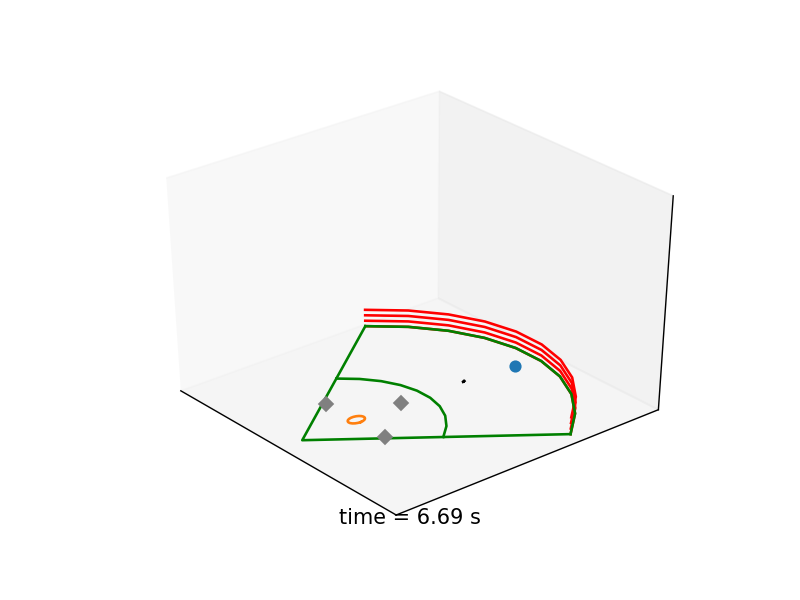

In [11]:
inplay = batted_ball()
inplay.struck(exit_speed=50, launch_angle=35, spray_angle=0, wind=[0,0])
# inplay.struck(exit_speed=75, launch_angle=5, spray_angle=20, wind=[0,0])
inplay.in_flight()
inplay.ball_travel()
inplay.plot_3d()


In [210]:
#old inplay
inplay = batted_ball()
inplay.struck(exit_speed=65,launch_angle=25,spray_angle=-12, wind=[20,0])
# inplay.struck(exit_speed=65,launch_angle=20,spray_angle=0, wind=[20,0])

inplay.in_flight()

print("mph",inplay.exit_speed/1.467)
print('final v mph_air', inplay.ball_velos[5])
# print("velo ", np.sqrt(inplay.ball_velos[0]**2 + inplay.ball_velos[1]**2), inplay.ball_velos[2],'mph',inplay.ball_velos[5])

inplay.bounce()
# inplay.spray_angle
print('mph after bounce',inplay.bounced_ball_velos[3])
# print('difference in bounce from dirt to grass')

print('x, y, z', inplay.ball_xx[-1], inplay.ball_yy[-1], inplay.ball_zz[-5:])

inplay.in_flight(x0 = inplay.ball_xx[-1], y0=inplay.ball_yy[-1], z0 = inplay.ball_zz[-1])

mph 65.0
final v mph_air 54.175870595449695
mph after bounce 37.57212997219013
x, y, z -41.439082205938114 195.38903749487088 [9.92998393 9.61366078 9.29484476 8.97353972 8.64974957]


In [98]:
# getting data
inplay = pitch1
x = inplay.ball_xx; y = inplay.ball_yy; z = inplay.ball_zz
r = inplay.ball_rr; t = inplay.tt
r[-1]

199.90752453887936

<IPython.core.display.Javascript object>


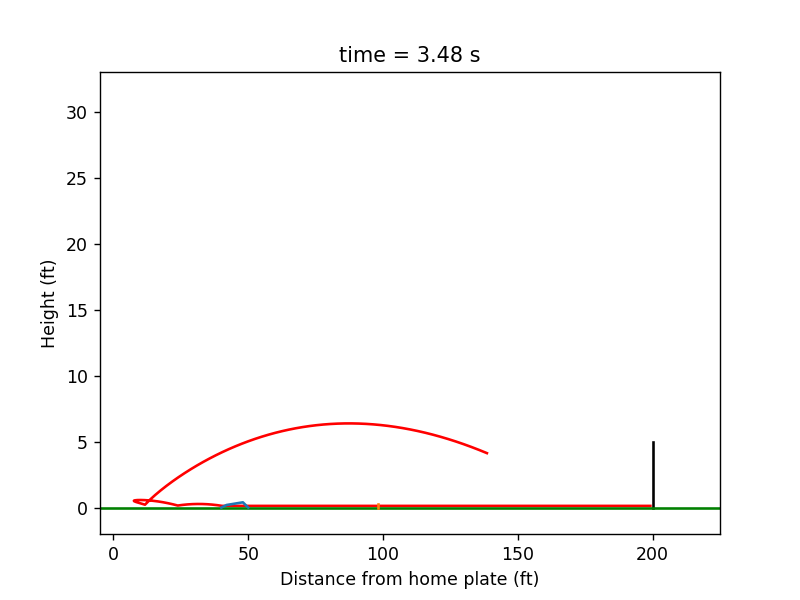

199.76249849992803


In [88]:
# Plot distance vs height
import datetime
fence = inplay.fence_dist
step = 2
tt = len(t) / step
fig, ax = plt.subplots()
line, = ax.plot(r, z,color = 'r')
ax.plot([fence,fence],[0,5],'k') #outfield fence
ax.plot([-10,240],[0,0],'g') #ground
ax.plot([40,42,48,50],[0,.2,.4,0]) #mound
ax.plot([98,98],[0,.3]) #cut of outfield at 2b
ax.axis([-5, 225, -2, 33])

plt.xlabel('Distance from home plate (ft)')
plt.ylabel('Height (ft)')
plt.title('Hangtime = %.2f s' %t[-1])
# start = datetime.datetime.now()
for n in range(math.ceil(tt)):
    ht = t[n*step]
    plt.title('time = %.2f s' %ht) #TODO make this total time instead of time since last bounce
    line.set_data(r[1:(step*n)], z[1:(step*n)])
    fig.canvas.draw()
print(r[-1])
# print('t last', t[-1])
# print("time elapsed to plot",datetime.datetime.now() - start)

<IPython.core.display.Javascript object>


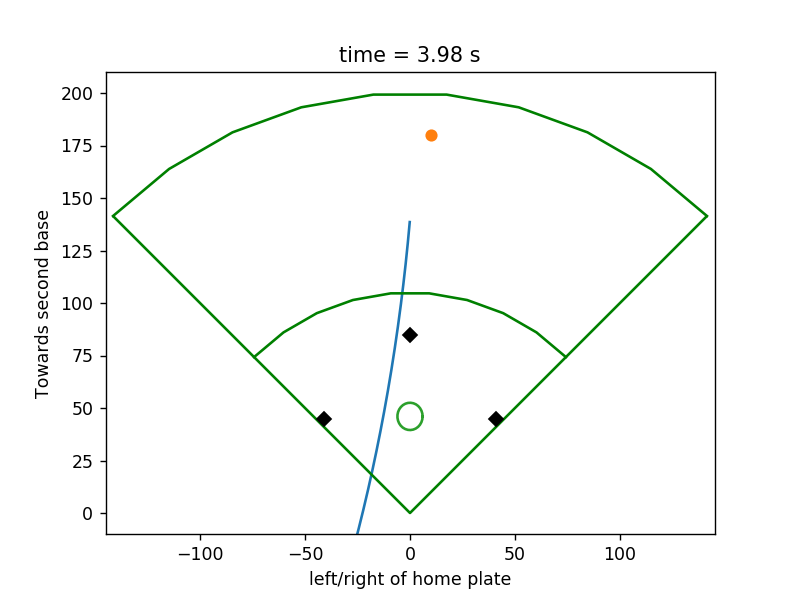

In [99]:
# Plot overhead view
step = 2
fence = inplay.fence_dist
tt = len(t) / step
cf_x = np.linspace(0, 10, math.ceil(tt))
cf_y = np.linspace(140,180, math.ceil(tt))

fig, ax = plt.subplots()
line, = ax.plot(x,y)
fielders, = ax.plot(cf_x,cf_y,'o')

arc= np.linspace(np.pi/4,3*np.pi/4, 10)
inf_x = [105*np.cos(c) for c in arc]
inf_y = [105*np.sin(c) for c in arc]
fence_x = [fence*np.cos(c) for c in arc]
fence_y = [fence*np.sin(c) for c in arc]
mound_x = [6*np.cos(c) for c in np.linspace(0,2*np.pi-.01,30)]
mound_y = [6.5*np.sin(c)+46 for c in np.linspace(0,2*np.pi-.01,30)]

ax.plot(mound_x,mound_y) #mound
ax.plot([-141,0,141],[141, 0, 141], 'g') #foul lines
ax.plot(fence_x,fence_y,'g') #homer fence
ax.plot(inf_x, inf_y,'g') #infield cut
ax.plot([-41, 0, 41],[45,84.6,45],'Dk') #bases
ax.axis([-145, 145, -10, 210])

plt.xlabel('left/right of home plate')
plt.ylabel('Towards second base')
plt.title('time = %.2f s' %t[-1])
plt.gca().set_aspect('equal')
# start = datetime.datetime.now()
for n in range(math.ceil(tt)):
    ht = t[n*step]
    plt.title('time = %.2f s' %ht)
    line.set_data(x[1:(step*n)], y[1:(step*n)])
    fielders.set_data(cf_x[n],cf_y[n])
#     ax.axis([-145, 145, -10, 210])
    fig.canvas.draw()
    


<IPython.core.display.Javascript object>


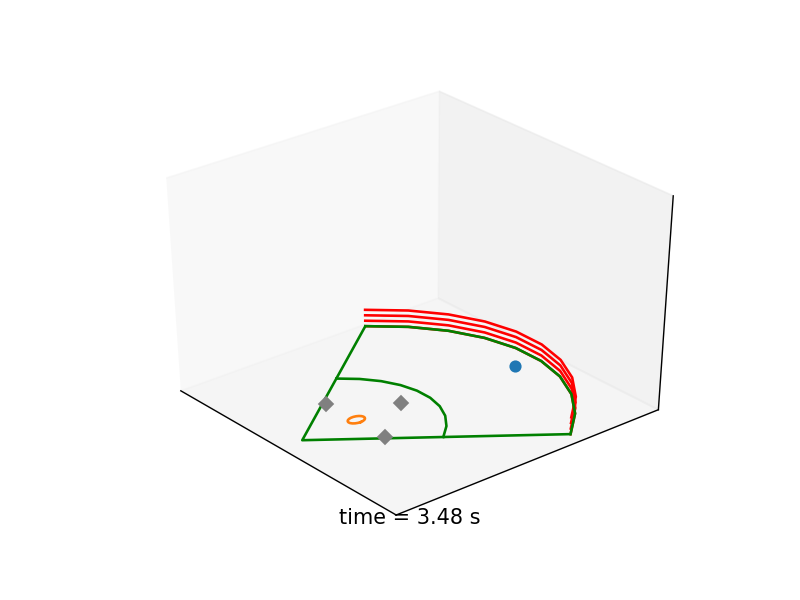

In [90]:
#3d plotting
# from mpl_toolkits import mplot3d
fielder_x = cf_x; fielder_y  = cf_y
fig, ax = plt.subplots()
ax = plt.axes(projection='3d')
line, = ax.plot3D(x,y,z, 'black')
fielders, = ax.plot3D(fielder_x,fielder_y,0,'o')
# fielders, = ax.scatter(fielder_x,fielder_y, cmap='Greens');

# ax.view_init(10, -90) #directly behind the plate
ax.view_init(35, -40) #1b dugout

ax.set_xlim(-145,145)
ax.set_ylim(-10, 210)
ax.set_zlim(0,35) 
ax.grid(False)
# Hide axes ticks
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

arc= np.linspace(np.pi/4,3*np.pi/4, 10)
inf_x = [105*np.cos(c) for c in arc]; inf_y = [105*np.sin(c) for c in arc]
fence_x = [200*np.cos(c) for c in arc]; fence_y = [200*np.sin(c) for c in arc]
mound_x = [6*np.cos(c) for c in np.linspace(0,2*np.pi,20)]
mound_y = [6.5*np.sin(c)+46 for c in np.linspace(0,2*np.pi,20)]

for i in range(4):
    #TODO fix the height so that it is on the same scale as the xy
    ax.plot3D(fence_x, fence_y,[i]*len(fence_x),'r') #outfield fence 

ax.plot(mound_x,mound_y) #mound
ax.plot([-141,0,141],[141, 0, 141], 'g') #foul lines
ax.plot(fence_x,fence_y,'g') #homer fence
ax.plot(inf_x, inf_y,'g') #infield cut
ax.plot([-41, 0, 41],[45,84.6,45],'D',color='grey') #bases
#bases are 15in (1.25 ft) per side if I want to graph that. Will have to find location of each corner

trail = 30
# step = 3
tt = len(t) / step 
fielder_x = np.linspace(0, 10, math.ceil(tt)); fielder_y = np.linspace(140,180, math.ceil(tt))

for n in range(math.ceil(tt)):
    ht = t[n*step]
    plt.title('time = %.2f s' %ht)
    
#     #plot everything
#     line.set_xdata(x[1:(step*n)]) 
#     line.set_ydata(y[1:(step*n)])
#     line.set_3d_properties(z[1:(step*n)])
    if step*n-trail < 0:
        line.set_xdata(x[1:(step*n)]) 
        line.set_ydata(y[1:(step*n)])
        line.set_3d_properties(z[1:(step*n)])
    else:
        line.set_xdata(x[step*n-trail:(step*n)]) 
        line.set_ydata(y[step*n-trail:(step*n)])
        line.set_3d_properties(z[step*n-trail:(step*n)])
        
    fielders.set_xdata(fielder_x[n])
    fielders.set_ydata(fielder_y[n])
    fielders.set_3d_properties(0)
    fig.canvas.draw()



# 10/13/20 todo
 - hitters control 80% of exit velocity, pitchers control 20%? maybe 2/3 and 1/3 for LL. But pitchers have more influence over launch angle
     - maybe start with a whiff rate on swings, work backward to determine STD of "hard to make contact" rolls? Will have to determine a launch angle (using hitter contact) and exit velo (using power with a little contact) 
     - maybe have a constant base pitcher difficulty to hit (by pitch, aka velo/movement) with a varying location and pitch mix modifier. 
     
 -  DONE graph batted balls
     - add fielders (with reads/jumps, speed, glove determines if they make they play while sprinting or if they make diving play)
         - this will open up the possibility of ranking plays by % chance of making them, or just by stars like MLB. % chance both for that individual fielder and compared to league average
     - determine fair/foul
     - determine caught/not
     - DONE add ground balls
     
 ## 1/5/21 pitching
 - DONE should be able to use the hitting equations for pitching! just input a spin rate and turn around spray angle, input release point, graph pitches from release to catcher. 
 - https://www.drivelinebaseball.com/2019/01/deeper-dive-fastball-spin-rate/ -For now I'll use major league spin rates, but could use Bauer units instead
 - TODO add catcher handling balls in dirt
    
## 1/5/21 Hitting
- location of pitch, speed, movement determine how hard to hit
    - hitter skills vs pitcher attributes determine quality of contact, which determines launch angle, which feeds in to ball travel function
    - need to interject "pitch is hit" event in to pitching function. Maybe combine plots? Maybe not, can leave pitch and swing separate. 
    - see above, might need to work backwards from whiff rate on swings to determine the chances to hit and etc
    
     
     
     
     
 - graph pitches? 
     - allow user to call each pitch
     - allow user to come up with a sign system. 
         - too complicated and the game will slow down + catcher mess up some signs. Too simple and other teams with smart coaches will pick pitches. Make them give signs! Hit buttons or click things

In [297]:
#Pitch calculating and plotting
    
class pitch:
    def throw(self,exit_speed, release_angle, spray_angle,backspin=1700, sidespin = -300, gyrospin=0, pitcher_hand="r"):
        wind = [0,0]  #not using wind in pitching
        self.spray_angle = spray_angle #180 spray angle to go straight towards plate
        self.release_angle = release_angle 
        self.exit_speed = exit_speed * 1.467 #getting to ft/s
        mass, self.circumference = 5.125,9.125
        self.R = self.circumference/ np.pi /2
        self.cl0,self.cl1,self.cl2 = .583,2.333,1.120
        self.cd0, self.cdspin, self.c0= .3008, .0292, .00537
        self.tau = 10000 #values 30 or 10000 (very slow). Has to do with spin rate decay
        vwind, phiwind = wind[0] * 1.467, wind[1] #ft/s for vwind
        self.vxw = vwind * np.sin(phiwind*np.pi/180);  self.vyw = vwind * np.cos(phiwind*np.pi/180) #ft/s
        if pitcher_hand == "r" or pitcher_hand == "R": sign = 1 
        else: sign = -1
        theta, phi = release_angle, spray_angle
        self.wb = backspin #positive is backspin
        self.ws = sidespin * sign #positive sidespin gives cut/slider for either hand, negative for 2seam run
        self.wg = gyrospin * sign #unknown which is which, and can't easily figure it out from ball flight
        self.ball_xx = np.empty(0);  self.ball_yy = np.empty(0); self.ball_zz = np.empty(0)
        self.ball_rr = np.empty(0);  self.tt = np.empty(0)
        self.first_time_flag = True
        
        #TODO need to add backstop handling
        self.backstop_dist = -20; self.at_backstop = False
        self.fence_dist = 200
        self.outfield_grass = 105 #ft, for plotting
        self.bounce_num = 0
        self.bounced_ball_velos = [0,30,30]
        self.dt = .01
        self.wild_pitch = False
        self.catcher_caught = False
        self.plot_step = 1
        return
        
    def catch_pitch(self, location, targetx=0, targety=-2, targetz=2.5, catch_range=[1.5,.25,2]):
        #location = current [x,y,z] of ball
        #default x catch range is width of plate (18 inches). z is 2 feet
        if location[0] > targetx + catch_range[0] or location[0] < targetx - catch_range[0]: 
            # if current x > targetx + catch range or x < target - catch range:
            self.wild_pitch = True
            return self #ball not caught
        if location[2] > targetz + catch_range[2] or location[2] < targetz - catch_range[2]:
            self.wild_pitch = True
            return self
        self.wild_pitch = False
        self.catcher_caught = True
        return self
        #TODO add handling bouncing balls
        
        
    def in_flight(self, x0=0, y0=42, z0=4.5): #default release point
        #wind[velo,angle[-180,180](0 out to center, -45 out to left, 45 out to right, 180 in from center)]
    #     pdb.set_trace()
        theta, phi = self.release_angle, self.spray_angle
        spin = np.sqrt(self.wb**2+self.ws**2)
        cd = self.cd0+self.cdspin*(spin/1000) #this is the equation from the top section of the excel
        omega = np.sqrt(self.wb**2 + self.ws**2) * np.pi/30 #initial spin, rad/s
        romega = (self.circumference/2/np.pi) * omega/12 #initial spin, ft/s
        v0 = self.exit_speed #ft/s, converted in throw
        v0x = v0*np.cos(theta*np.pi/180) * np.sin(phi*np.pi/180);  v0y = v0*np.cos(theta*np.pi/180) * np.cos(phi*np.pi/180)
        v0z = v0*np.sin(theta*np.pi/180)
        wx =(self.wb*np.cos(phi*np.pi/180) - self.ws*np.sin(theta*np.pi/180)*np.sin(phi*np.pi/180)+self.wg*v0x/v0)*np.pi/30
        wy =(-self.wb*np.sin(phi*np.pi/180)-self.ws*np.sin(theta*np.pi/180)*np.cos(phi*np.pi/180)+self.wg*v0y/v0)*np.pi/30
        wz = (self.ws*np.cos(theta*np.pi/180)+self.wg*v0z/v0)*np.pi/30
        x_last, y_last, z_last = x0, y0, z0;  vx_last,vy_last,vz_last = v0x, v0y, v0z
        ax_last, ay_last, az_last = 0, -10, -32.174 #moderate value for starting y decel, z is gravity
        
        if self.first_time_flag:
            time_range = np.arange(0, 2+self.dt, self.dt)
            #start data at index 1, 0 is for initial values
            ball_x = np.zeros(len(time_range)+1); ball_y = np.zeros(len(time_range)+1); ball_z = np.ones(len(time_range)+1)
            ball_r = np.zeros(len(time_range)+1)
            self.first_time_flag = False
            tick = 0
        else:
            later_start = self.tt[-1] + self.dt
            time_range = np.arange(later_start, later_start+5, self.dt) #see if 5 is long enough for a huge bounce
            ball_x = np.empty(len(time_range)); ball_y = np.empty(len(time_range)); ball_z = np.empty(len(time_range));
            ball_r = np.empty(len(time_range)); 
            tick = -1 #start with tick 0, because data starts at index 0 this time around

        ball_x[0], ball_y[0], ball_z[0] = x0, y0, z0
        for t in time_range:
            tick += 1
            vx = vx_last + ax_last*self.dt; vy = vy_last + ay_last*self.dt; vz = vz_last + az_last*self.dt
            v = np.sqrt(vx**2 + vy**2 + vz**2)
#             vmph = v/1.467 #just to see it
            vw = np.sqrt( (vx-self.vxw)**2 + (vy-self.vyw)**2 +vz**2)   #using simplification: wind starts at ground level always
            cd = self.cd0 + self.cdspin*(spin/1000)* np.exp(-t/(self.tau*146.7/vw))
            S = (romega/vw) * np.exp(-t/(self.tau*146.7/vw));  Cl = self.cl2*S/(self.cl0 + self.cl1 *S); w = omega * np.exp(-t/self.tau)*30/np.pi

            aDragx = -self.c0 * cd*vw *(vx-self.vxw); aDragy = -self.c0 * cd*vw *(vy-self.vyw); aDragz = -self.c0 * cd*vw * vz        
            aMagx = self.c0*(Cl/omega) *vw *(wy *vz -wz*(vy -self.vyw)); aMagy = self.c0*(Cl/omega) *vw *(wz*(vx-self.vxw) - wx*vz); aMagz = self.c0*(Cl/omega) *vw *(wx*(vy - self.vyw) -wy*(vx-self.vxw))
            ax= aDragx + aMagx; ay = aDragy + aMagy; az = aDragz + aMagz - 32.174
            x = x_last + vx_last*self.dt + .5*ax_last*self.dt*self.dt; y = y_last + vy_last*self.dt + .5*ay_last*self.dt*self.dt; z = z_last + vz_last*self.dt + .5*az_last*self.dt*self.dt
            r = np.sqrt(x**2 + y**2)
            phi = np.arctan2(y,x)*180/np.pi
    #         print('x %s  y %s   z %s' %(x, y, z))

            x_last, y_last, z_last = x, y, z;   vx_last, vy_last, vz_last = vx, vy, vz;   ax_last, ay_last, az_last = ax, ay, az
            ball_x[tick], ball_y[tick], ball_z[tick], ball_r[tick] = x,y,z,r

            if y_last <= -2: #cut out the time steps after ball gets to catcher, if caught
                self.catch_pitch(location=[x,y,z], targetx=0, targety=-2, targetz=2.5, catch_range=[1.5,.25,2])
                if self.catcher_caught:
                    self.ball_xx = np.append(self.ball_xx, ball_x[:tick]);  self.ball_yy = np.append(self.ball_yy, ball_y[:tick])
                    self.ball_zz = np.append(self.ball_zz, ball_z[:tick]);  self.ball_rr = np.append(self.ball_rr, ball_r[:tick])
                    self.tt = np.append(self.tt, time_range[:tick])
                    self.ball_velos = [vx, vy, vz, self.wb,self.ws, v/1.467] #omega backspin, omega sidespin
                    self.spray_angle = np.degrees(np.arctan2(vx,vy))
    #                 print('ball_velo about to hit ground ', vx, vy, vz)
                    break
#                 else: #if there is a wild pitch
#                     continue
            
            if z_last <= .13: #cut out the time steps after ball touches ground (.13 is radius in ft, track center of ball)
                if y <= self.backstop_dist:
                    self.at_backstop = True
                self.ball_xx = np.append(self.ball_xx, ball_x[:tick]);  self.ball_yy = np.append(self.ball_yy, ball_y[:tick])
                self.ball_zz = np.append(self.ball_zz, ball_z[:tick]);  self.ball_rr = np.append(self.ball_rr, ball_r[:tick])
                self.tt = np.append(self.tt, time_range[:tick])
                self.ball_velos = [vx, vy, vz, self.wb,self.ws, v/1.467] #omega backspin, omega sidespin
                self.spray_angle = np.degrees(np.arctan2(vx,vy))
#                 print('ball_velo about to hit ground ', vx, vy, vz)
                break
        return 
            #using constant spray angle right now
        
    def bounce(self):
#         https://tht.fangraphs.com/the-physics-and-timing-of-the-infield-bounce-throw/
        xbounce = self.ball_xx[-1]; ybounce = self.ball_yy[-1]
        rbounce = self.ball_rr[-1]
        self.bounce_num += 1
#         print('bounce ', self.bounce_num)
        #if we're on dirt (all dirt plate area right now)
        COR = np.random.normal(.562, .15) 
        COF = np.random.normal(.4, .05)
#         print('COR dirt', COR, 'COF', COF)

        vx1 = self.ball_velos[0]; vy1 = self.ball_velos[1]; vz1 = self.ball_velos[2]
        wb1 = self.ball_velos[3]; ws1 = self.ball_velos[4]
        vxy1 = np.sqrt(vx1**2 + vy1**2) #total radial or forward velocity
        
        vxy2 = vxy1 + COF*(1 + COR)* vz1
        vz2 = -COR * vz1
        wb2 = wb1 + (COF * (1+COR)*vz1/ 0.4 * self.R)
        v2 = np.sqrt(vxy2**2 + vz2**2)
#         print("vxy1 %f  vxy2 %f  wb1 %f  wb2 %f  vz1 %f vz2 %.2f" %(vxy1, vxy2,wb1,wb2, vz1,vz2))
        self.release_angle = np.degrees(np.arctan2(vz2,vxy2))
        #NOTE: left handed curve from pitcher pov, ball goes left after bounce. Started moving right
        self.exit_speed = v2 #leave in ft/s
        self.bounced_ball_velos = [vxy2, vz2, v2, v2/1.467 ] 
#         print("v z after bounce", vz2, "     v after bounce", v2/1.467)
        return
       
    def get_roll_angle(self, vy, vx):
        theta0 = np.arctan2(vy,vx)
        if theta0 < 0 and vy > 0: #vy > 0 makes rolling decelerate when it's fouled back/moving towards plate
#         if theta0 < 0:
            theta0 += np.pi
        return theta0
        
    def roll(self):
#         vz1 = self.ball_velos[2] #treat as if vz=0, at least until a bad hop #TODO add bad hops
        vx_last = self.ball_velos[0]; vy_last = self.ball_velos[1]
        vxy = np.sqrt(vx_last**2 + vy_last**2) #total radial or forward velocity
        later_start = self.tt[-1] + self.dt
        time_range = np.arange(later_start, later_start+8, self.dt) #assuming fielder always reaches ball within 8 seconds of starting roll
        ball_x = np.empty(len(time_range)); ball_y = np.empty(len(time_range)); ball_z = np.empty(len(time_range));
        ball_r = np.empty(len(time_range)); 
        tick = -1 #start with tick 0, because data starts at index 0 this time around
        x_last, y_last = self.ball_xx[-1], self.ball_yy[-1];  r = self.ball_rr[-1]
        theta0 = self.get_roll_angle(vy_last, vx_last)
        
        if vxy <= 1:  #if the x-y velocity is less than 1 at the start, skip the roll and be finished. 
            print('roll: no speed, returning')
            return
        while vxy > 1 and self.at_backstop is not True and self.caught is False: #and not caught # while magnitude of speed over 1mph
            if tick >= len(time_range):
                print('about to break')
                break
                
            a = -2 #medium gets -2 14mph to 0 in 10s #for dirt surface
            tick += 1
            vtheta = self.get_roll_angle(vy_last, vx_last)
            ay = a * np.sin(vtheta)
            ax = a * np.cos(vtheta)  
            
#             print("ay %.2f,  ax %.2f" %(ay,ax))
            x = x_last + vx_last*self.dt + .5*ax*self.dt*self.dt;  y = y_last + vy_last*self.dt + .5*ay*self.dt*self.dt
            r = np.sqrt(x**2 + y**2)
            vx = vx_last + ax*self.dt;  vy = vy_last + ay*self.dt
            vxy = np.sqrt(vx**2 + vy**2)
            
            x_last, y_last = x, y;   vx_last, vy_last = vx, vy
            ball_x[tick], ball_y[tick], ball_z[tick], ball_r[tick] = x,y,.13,r  #.13 is ball radius in ft
            if y <= self.backstop_dist:
                    self.at_backstop = True
        self.ball_xx = np.append(self.ball_xx, ball_x[:tick]);  self.ball_yy = np.append(self.ball_yy, ball_y[:tick])
        self.ball_zz = np.append(self.ball_zz, ball_z[:tick]);  self.ball_rr = np.append(self.ball_rr, ball_r[:tick])
        self.tt = np.append(self.tt, time_range[:tick])
#         self.ball_velos = [vx, vy, self.ball_velos[2], self.wb,self.ws, vxy/1.467] #omega backspin, omega sidespin
        return
        
    def ball_travel(self):        
        while self.at_backstop is not True:
            if self.catcher_caught:
                return

            if self.bounced_ball_velos[1] > 3: #checks vertical part of velo after bounce (a hard roller can exist)
                self.bounce()
                self.in_flight(x0=self.ball_xx[-1], y0=self.ball_yy[-1], z0=self.ball_zz[-1])
            else:
                x=0
                self.roll()
                #TODO add sit_still() function? To add the same location for more time if a ball is stopped before fielder
                #gets to it
                return
            return
            
    def plot_3d(self):
        # from mpl_toolkits import mplot3d
        #TODO input fielders
        step = self.plot_step
        tt = len(self.tt) / step 
        fielder_x = np.linspace(0, 10, math.ceil(tt))
        fielder_y = np.linspace(140,180, math.ceil(tt))

        fig, ax = plt.subplots()
        ax = plt.axes(projection='3d')
        line, = ax.plot3D(self.ball_xx,self.ball_yy,self.ball_zz, 'black')
#         fielders, = ax.plot3D(fielder_x,fielder_y,0,'o')
        # fielders, = ax.scatter(fielder_x,fielder_y, cmap='Greens');

#         ax.view_init(15, -85) #directly behind the plate
        ax.view_init(10, -30) #1b dugout
#         ax.view_init(35,-130) #3b dugout

        #TODO this is all wrong, needs to be backstop fence
        pdist = 50
        ax.set_xlim(-pdist/2*.7071,pdist/2*.7071)
        ax.set_ylim(-2, pdist+3)
        ax.set_zlim(0,15) 
        ax.grid(False)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])  # Hide axes ticks
        
        #TODO this is all wrong too
        arc= np.linspace(np.pi/4,3*np.pi/4, 10)
#         inf_x = [self.outfield_grass*np.cos(c) for c in arc]; inf_y = [self.outfield_grass*np.sin(c) for c in arc]
#         fence_x = [self.fence_dist*np.cos(c) for c in arc]; fence_y = [self.fence_dist*np.sin(c) for c in arc]
        mound_x = [6*np.cos(c) for c in np.linspace(0,2*np.pi,20)]
        mound_y = [6.5*np.sin(c)+46 for c in np.linspace(0,2*np.pi,20)]

#         for i in range(4):
#             ax.plot3D(fence_x, fence_y,[i]*len(fence_x),'r') #outfield fence 

        ax.plot3D([0]*4,[45,46,44,45],[1,4,4,1]) #pitcher body
        ax.plot3D([0]*5,[44,46,46,44, 44],[4,4,5,5,4]) #pitcher head
        ax.plot3D([-3]*4,[0,1,-1,0],[1,4,4,1]) #hitter body
        ax.plot3D([-3]*5,[-1,1,1,-1, -1],[4,4,5,5,4]) #hitter head
        ax.plot3D([-1.5,-1.5,1.5,1.5, -1.5],[0]*5,[1.5,4,4,1.5,1.5]) #strike zone

        ax.plot(mound_x,mound_y) #mound
#         foul_pole = .7071*self.fence_dist
        ax.plot([-pdist*.7071,0,pdist*.7071],[pdist*.7071, 0, pdist*.7071], 'g') #foul lines
#         ax.plot(fence_x,fence_y,'g') #homer fence
#         ax.plot(inf_x, inf_y,'g') #infield cut
        ax.plot([-41, 0, 41],[45,84.6,45],'D',color='grey') #bases
        #bases are 15in (1.25 ft) per side if I want to graph that. Will have to find location of each corner

        fielder_x = np.linspace(0, 10, math.ceil(tt)); fielder_y = np.linspace(140,180, math.ceil(tt))        
        
        trail = 15
        for n in range(math.ceil(tt)):
            ht = self.tt[n*step]
#             plt.title('time = %.2f s' %ht)

            if step*n-trail < 0:
                line.set_xdata(self.ball_xx[1:(step*n)]) 
                line.set_ydata(self.ball_yy[1:(step*n)])
                line.set_3d_properties(self.ball_zz[1:(step*n)])
            else:
                line.set_xdata(self.ball_xx[step*n-trail:(step*n)]) 
                line.set_ydata(self.ball_yy[step*n-trail:(step*n)])
                line.set_3d_properties(self.ball_zz[step*n-trail:(step*n)])

#             fielders.set_xdata(fielder_x[n])
#             fielders.set_ydata(fielder_y[n])
#             fielders.set_3d_properties(0)
            fig.canvas.draw()
        
        plt.title('time = %.2f s' %ht)
        return
        
        #TODO add pitching/hitting equations- exit speed and launch angle, velo and movement and location
        #TODO add fielding - read, accel, speed to close towards ball. Glove rating to catch
            #future bad hop too close to fielder adds difficulty modifier to play
        

<IPython.core.display.Javascript object>


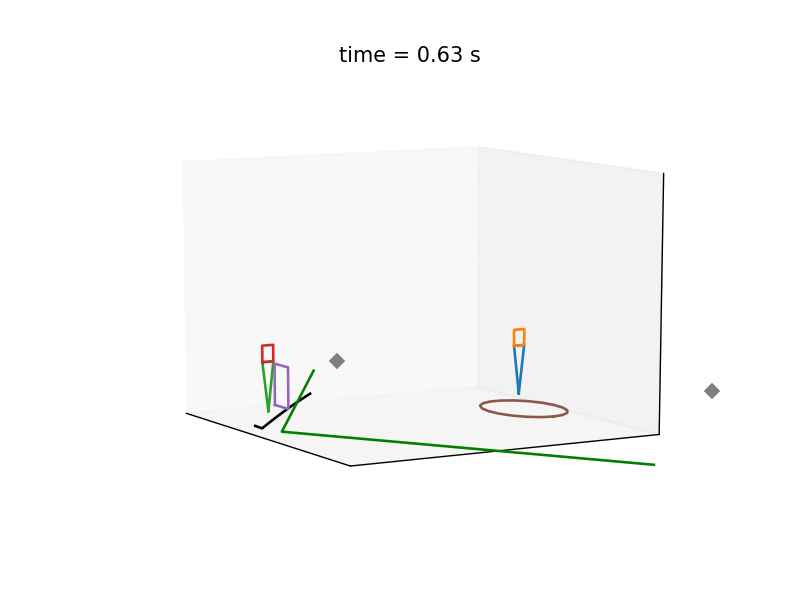

In [302]:
pitch1 = pitch()
# pitch1.throw(exit_speed=60, release_angle = 2, spray_angle=181, backspin=1400, sidespin=-1000, gyrospin=0, pitcher_hand='l')
# pitch1.throw(exit_speed=60, release_angle = 2, spray_angle=181, backspin=1800, sidespin=0, gyrospin=0, pitcher_hand='l')
pitch1.throw(exit_speed=53, release_angle = 4, spray_angle=181, backspin=-1700, sidespin=500, gyrospin=0, pitcher_hand='l')


pitch1.in_flight(x0=0, y0=42, z0=4)
pitch1.ball_travel()
pitch1.plot_3d()

In [ ]:
#hitting equation - skill based idea
#10/22/2019
#most simulations use hitter vs pitcher skill, with ability to not make an out. 
#this paper https://cdn.shopify.com/s/files/1/1633/3369/files/VersionFinale.pdf  uses the chance of each of 9 outcomes, being 
# Player       1B      2B     3B     HR     BB     HBP    SO    GO      FO
# Ryan Howard 0.1211 0.0521 0.0056 0.0634 0.1056 0.0085 0.2620 0.1916 0.1901

#https://www.baseballprospectus.com/news/article/9503/checking-the-numbers-pujols-and-the-simulation-gauntlet/
#uses Bill James "odds ratio", example is for making an out
# Odds(Hitter) = 0.6241 / (1-0.6241) = 1.66
# Odds(Pitcher) = 0.6720 / (1-0.6720) = 2.05
# Odds(League) = 0.65 / (1-0.65) = 1.86
# Odds = Odds(H) * (Odds(P)/Odds(L))
# Odds = 1.66 * (2.05/1.86)  = 1.829
# Rate of Making an Out = 1.829 / (1+1.829) = 0.6465

#I am going to start by simming balls in play (for the at bat, not per pitch).
# roll for quality of contact, roll for power. Swing position [0,1] with contact being a range [-skill, swing center, +skill].
#Ex. contact skill with center .50 [.35,.65]. This gives .65-.35=.3 chance of making contact. 
#   if someone is a ground ball/fly ball hitter, move the center up or down.
# TODO just check for contact, then roll power with thresholds for single, double, triple, homer
# TODO add chance of walk and hbp, check for those before checking contact. 

#NEXT correspond contact values to launch angle, make contact vary by standard deviation instead of random 
#NEXT exit speed, launch angle, physics-based travel distance and time which can be used with fielder skills.
#ADVANCED: from fielder reads, speed, starting position- calculate if they get to a ball and if they make the play
#ADVANCED: sim pitches thrown to locations, batter strengths by location and where the ball goes when hit 

In [ ]:
#pitching idea - graph the trajectory of each pitch from the side, and tell if it hit the catchers glove, catchers legs,
    # or catcher reached. Then one of the events will be that the catcher doesn't set up in reasonable spots and that's why
    #pitches were going to a different spot than you thought

In [ ]:
# 1/9/2020 TODO
# maybe make player self.skill and self.stat into a pandas series. Check how much would need to be rewritten to do that
# update stats for entire team with the pandas series? 

